In [74]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

Some warnings popping for NumPy support for python version > 3.6. Looks like they still haven't resolved it<br>
https://github.com/OSGeo/gdal/issues/3444

####  Q1 Score Prediction

In order to create a more "comprehensive" classification problem, I decided to devide the scores in bands of 5 (initially 10 but I figurured it was perhaps few?). Then based on that I generated a SVM classifier, following similar steps as we did in class. <br>
As I mention in multiple steps, I am not sure if I made the correct decision to not in someway format the groups of columns, and make it somehow more "clear" to the machine that groups of features belong to the same topic and are related somehow.<br><br>
I thought of a model that I could use, but did not put it to work. For instance on Color, we could format each column to have a value of 10, 100, 1000 etc. and combine these in a single feature. That is not so helpful for colors, but perhaps would be more visibly useful in flavours, where one scotch may have maple(10) & vanilla(1000) flavour, adding up to a score of 1010. Following this would on the other hand drop the feature columns by a lot, so I was unsure if: a) it was useful, b) correct approach. <br> Unfortunately I was very restricted by time to simply test it. But I would be very happy to hear from you what I did wrong in various steps that I note further bellow as well.

In [3]:
scotchSumOr = pd.read_excel('./ScotchData/scotch.xlsx', header=1)
print(scotchSumOr.shape)
scotchSumOr.sample(5)

(111, 85)


,NAME,Unnamed: 1,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
75,Knockdhu,Knockdhu,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Scapa,Scapa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ORKNEY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
93,Saint Magdalene,Saint Magd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,CENTRAL,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
81,Lochnagar,Lochnagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,EAST,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30,Dalmore,Dalmore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NORTH,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Data cleaning is taking place, removing unnecessary columns and NAN values. I'm also cleaning the strings of the Dataframe of whitespaces. 

In [4]:
scotchSum = scotchSumOr.drop(scotchSumOr.columns[[0,1]], axis=1)
scotchSum.sample(5)

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,WEST,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,MIDLAND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
scotchSum.dropna(subset = ["SCORE"], inplace=True)

In order to classify groups of items we can split the scoring in groups: 0-5, 5-10, etc. Originally tried with 10

In [6]:
scotchSum["scoreGroup"] = pd.to_numeric(np.floor(scotchSum["SCORE"] / 5), downcast="integer")
scotchSum["scoreGroup"].head(5)

0    13
1    16
2    17
3    13
4    17
Name: scoreGroup, dtype: int8

In [7]:
scotchSum.drop('SCORE', axis=1, inplace=True)

In order to classify and include the district and regional information, I'm transforming the columns in categorical variables, assigning them a category code. That way I can manipulate them as integers, rather than strings

In [8]:
scotchSum["REGION"] = scotchSum["REGION"].str.replace(" ","")
scotchSum["DISTRICT"] = scotchSum["DISTRICT"].str.replace(" ","")

In [9]:
scotchSum["region"] = scotchSum["REGION"].astype('category')
scotchSum["district"] = scotchSum["DISTRICT"].astype('category')
scotchSum["scoreGroup"] = scotchSum["scoreGroup"].astype('category')

In [10]:
scotchSum["regionCode"] = scotchSum["region"].cat.codes
scotchSum["districtCode"] = scotchSum["district"].cat.codes

In [11]:
predictors = list(set(list(scotchSum.columns)) - set(list(["scoreGroup", "REGION", "DISTRICT","region","district","scoreGroupCode"])))

Initiallising the process, similar to what we did in class, by defining the groups as the output. I decided on a 80/20 split, as we don't have too much data to train the model with

In [12]:
X = scotchSum[predictors].values
y = scotchSum["scoreGroup"].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print(X_train.shape); print(X_test.shape)

(87, 82)
(22, 82)


In this step, I reran all the processes with different kernel options, without noticeable performance boosts. On the contrary, I noticed drop in model performance using other methods

In [14]:
svmModel = svm.SVC(kernel="linear",gamma=0.1)
svmModel.fit(X_train, y_train)
print(svmModel.support_vectors_)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [15]:
svmModel.predict(X_train)

array([15, 14, 13, 16, 13, 18, 15, 14, 15, 15, 16, 11, 15, 16, 17, 12, 12,
       14, 16, 13, 15, 11, 15, 14, 14, 13, 14, 16, 15, 16, 15, 13, 15, 15,
       17, 15, 13, 15, 15, 15, 15, 17, 15, 15, 18, 14, 15, 15, 13, 16, 15,
       18, 14, 15, 15, 14, 14, 18, 13, 14, 17, 15, 17, 16, 15, 15, 17, 15,
       17, 14, 13, 15, 15, 17, 15, 15, 15, 15, 13, 15, 14, 15, 12, 15, 13,
       15, 13])

In [16]:
print("Classification report for classifier %s:\n%s\n"
      % (svmModel, metrics.classification_report(y_train, svmModel.predict(X_train))))

Classification report for classifier SVC(gamma=0.1, kernel='linear'):
              precision    recall  f1-score   support

          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        37
          16       1.00      1.00      1.00         8
          17       1.00      1.00      1.00         8
          18       1.00      1.00      1.00         4

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87




In [17]:
yPredicted = svmModel.predict(X_test)

In [18]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, yPredicted))


Confusion matrix:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0]
 [1 0 2 0 0 0 0]
 [0 0 0 1 6 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 4 0 1]]


In [19]:
print(metrics.accuracy_score(y_test, yPredicted))
print(metrics.classification_report(y_test, yPredicted))

0.45454545454545453
              precision    recall  f1-score   support

          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.60      0.60      0.60         5
          14       0.00      0.00      0.00         3
          15       0.50      0.86      0.63         7
          16       0.00      0.00      0.00         2
          17       1.00      0.20      0.33         5

    accuracy                           0.45        22
   macro avg       0.30      0.24      0.22        22
weighted avg       0.52      0.45      0.41        22



In [20]:
scores = cross_val_score(svmModel, X, y, cv=5, scoring='accuracy')
scores

array([0.59090909, 0.36363636, 0.27272727, 0.40909091, 0.42857143])

In [21]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.412987012987013 0.05197239689289283


As we can see, our model is not performing great(45% accuracy), which leads us to believe two things. Either data transformation was bad, or applying PCA will allow us to focus on more correct components

#### Q2 PCA

In [22]:
from sklearn.decomposition import PCA

In [ ]:
Again I am following the process from the class lecture, but choosing to define the expected accuracy of the components explaining our data. 

In [23]:
pcaX_train = StandardScaler().fit_transform(X_train)
pcaX_test = StandardScaler().fit_transform(X_test)


In [24]:
n_components = 50
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(pcaX_train)
print(f'explained ratio:{pca.explained_variance_ratio_}')

explained ratio:[0.06103848 0.05080744 0.04591093 0.04386589 0.03740882 0.03490444
 0.03304715 0.03193652 0.03076882 0.0284917  0.02781527 0.02694634
 0.02585886 0.02559625 0.02287946 0.02214519 0.02161052 0.02141016
 0.01999211 0.01981804 0.01923157 0.01769331 0.01747036 0.01711864
 0.01625806 0.01600965 0.01531503 0.01474    0.01413573 0.01334209
 0.01301208 0.01204559 0.01151432 0.0105064  0.01034183 0.00986761
 0.00937961 0.00913831 0.00899704 0.00790414 0.00730683 0.00706495
 0.0067766  0.00674412 0.00647864 0.00588485 0.00563037 0.00535427
 0.00515809 0.00444605]


Let us decide the expected explained variance, instead of the number of components, and let the package decide the proper number

In [25]:
pca85 = PCA(n_components=0.85)
principalComponents85 = pca85.fit_transform(pcaX_train)
print(f'explained ratio:{pca85.explained_variance_ratio_}')
print(f'Shape:{pca85.components_.shape}')

explained ratio:[0.06103848 0.05080744 0.04591093 0.04386589 0.03740882 0.03490444
 0.03304715 0.03193652 0.03076882 0.0284917  0.02781527 0.02694634
 0.02585886 0.02559625 0.02287946 0.02214519 0.02161052 0.02141016
 0.01999211 0.01981804 0.01923157 0.01769331 0.01747036 0.01711864
 0.01625806 0.01600965 0.01531503 0.01474    0.01413573 0.01334209
 0.01301208 0.01204559 0.01151432 0.0105064  0.01034183]
Shape:(35, 82)


In [26]:
pca95 = PCA(n_components=0.95)
principalComponents95 = pca95.fit_transform(pcaX_train)
print(f'explained ratio:{pca95.explained_variance_ratio_}')
print(f'Shape:{pca95.components_.shape}')

explained ratio:[0.06103848 0.05080744 0.04591093 0.04386589 0.03740882 0.03490444
 0.03304715 0.03193652 0.03076882 0.0284917  0.02781527 0.02694634
 0.02585886 0.02559625 0.02287946 0.02214519 0.02161052 0.02141016
 0.01999211 0.01981804 0.01923157 0.01769331 0.01747036 0.01711864
 0.01625806 0.01600965 0.01531503 0.01474    0.01413573 0.01334209
 0.01301208 0.01204559 0.01151432 0.0105064  0.01034183 0.00986761
 0.00937961 0.00913831 0.00899704 0.00790414 0.00730683 0.00706495
 0.0067766  0.00674412 0.00647864 0.00588485 0.00563037 0.00535427
 0.00515809]
Shape:(49, 82)


So in this spot, I noticed a tradeoff between the number of components and the explained variance ratio. To get a solid 95% explained variance I needed about 50 new dimensions. Of course, this is quite the difference from our starting point, but I am testing to see if droping 10% of the expected ratio would still give us good results.

In [27]:
from math import ceil

# based on https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
def biplot(score, coeff, text, labels=None):
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(111, label='pcas')
    ax2 = fig.add_subplot(111, label='loading vectors', frame_on=False)
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()    
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    # draw scatterplot
    ax1.scatter(xs, ys, fc='k')
    for i, txt in enumerate(text):
        ax1.text(xs[i] + 0.05, ys[i], txt,
                    fontsize=12,
                    alpha=0.75,
                    c='blue')
    
    # draw loading vectors
    for i in range(n):
        ax2.arrow(0, 0, coeff[i,0] * 0.85, coeff[i,1] * 0.85, 
                  lw=1,
                  color = 'r',alpha = 0.5, head_width=0.025, head_length=0.025)
        if labels is None:
            ax2.text(coeff[i,0], coeff[i,1], "Var"+str(i+1), 
                     color = 'g', ha = 'center', va = 'center')
        else:
            ax2.text(coeff[i,0], coeff[i,1], 
                     labels[i], color = 'brown', ha = 'center', va = 'center',
                     fontsize=14)
    
    xmax = max(xs.min(), xs.max(), key=abs)
    xlim = 0.5 * ceil(2.0 * xmax)
    ax1.set_xlim(-xlim, xlim)
    ymax = max(ys.min(), ys.max(), key=abs)
    ylim = 0.5 * ceil(2.0 * ymax)
    ax1.set_ylim(-ylim, ylim)
    ax1.axhline(0, linestyle=':', color='k', lw=0.5) # horizontal lines
    ax1.axvline(0, linestyle=':', color='k', lw=0.5) # vertical lines
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)

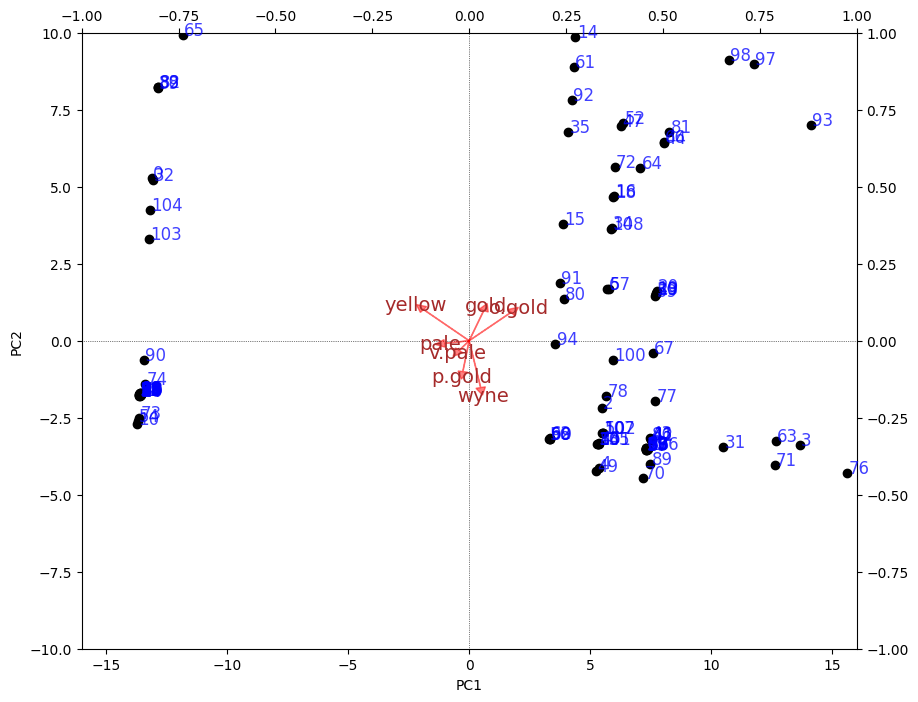

In [28]:
X_proj = pca.fit_transform(X)

plt.style.use('default')

biplot(X_proj,
       pca95.components_[:, 0:7].T,
       scotchSum.index,
       scotchSum.columns)

Now we can transform and compare the prediction outcome

In [72]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [76]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
clf.best_estimator_

SVC(C=1000.0, class_weight='balanced', gamma=0.1)

In [77]:
y_pred = clf.predict(X_test_pca)

In [80]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         3
          15       0.29      0.86      0.43         7
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         5

    accuracy                           0.27        22
   macro avg       0.06      0.17      0.09        22
weighted avg       0.09      0.27      0.14        22



Note to professor: I suspect lack of data handling. I'll reach out for a bit of your input, of how I should have handled the Data initially. I'd like to retry the process in more depth.

In [29]:
from sklearn.cluster import KMeans

In [30]:
scotchCl = scotchSumOr.drop(scotchSumOr.columns[[0,1]], axis=1)
scotchCl.sample(5)
scotchCl["REGION"] = scotchCl["REGION"].str.replace(" ","")
scotchCl["DISTRICT"] = scotchCl["DISTRICT"].str.replace(" ","")
scotchCl["REGION"] = scotchCl["REGION"].astype('category')
scotchCl["DISTRICT"] = scotchCl["DISTRICT"].astype('category')

In [61]:
scotchCl.columns

Index(['wyne', 'yellow', 'v.pale', 'pale', 'p.gold', 'gold', 'o.gold',
       'f.gold', 'bronze', 'p.amber', 'amber', 'f.amber', 'red', 'sherry',
       'AROMA', 'PEAT', 'SWEET', 'LIGHT', 'FRESH', 'DRY', 'FRUIT', 'GRASS',
       'SEA', 'SHERRY', 'SPICY', 'RICH', 'soft', 'med', 'full', 'round',
       'smooth', 'light', 'firm', 'oily', 'full.1', 'dry', 'sherry.1', 'big',
       'light.1', 'smooth.1', 'clean', 'fruit', 'grass', 'smoke', 'sweet',
       'spice', 'oil', 'salt', 'arome', 'full.2', 'dry.1', 'warm', 'big.1',
       'light.2', 'smooth.2', 'clean.1', 'fruit.1', 'grass.1', 'smoke.1',
       'sweet.1', 'spice.1', 'oil.1', 'salt.1', 'arome.1', 'ling', 'long',
       'very', 'quick', 'AGE', 'DIST', 'SCORE', '%', 'REGION', 'DISTRICT',
       'islay', 'midland', 'spey', 'east', 'west', 'north ', 'lowland',
       'campbell', 'islands'],
      dtype='object')

#### Q3 Clustering without Geographical Information

Thought process: Scotch with similar attributes should be getting similar scores. So a great algorithm to test that is k-means. This is what I am applying in both cases. <br> Unsure if, as before, some better approach should be taken to imporove the data structure. Again following class examples. 

In [32]:
scotchClnoGeo = scotchCl.drop(["REGION", "DISTRICT",'islay', 'midland', 'spey', 'east', 'west', 'north ', 'lowland', 'campbell', 'islands'], axis=1)

In [33]:
scotchClnoGeo.dropna(subset = ["SCORE"], inplace=True)

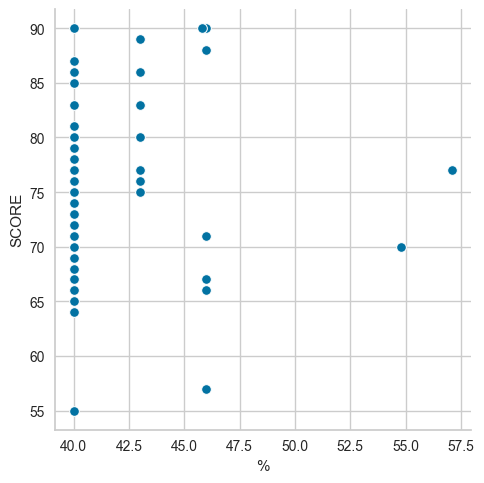

In [43]:
sn.relplot(x='%', y='SCORE', data=scotchClnoGeo)

In [35]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(scotchClnoGeo)
kmeans.cluster_centers_

array([[ 9.72222222e-02,  1.38888889e-02,  2.77777778e-02,
         4.16666667e-02,  9.72222222e-02,  2.22222222e-01,
         1.38888889e-02,  2.22222222e-01,  2.77777778e-02,
         4.16666667e-02,  1.25000000e-01,  1.38888889e-02,
         4.16666667e-02,  1.38888889e-02,  3.47222222e-01,
         4.30555556e-01,  4.58333333e-01,  1.25000000e-01,
         2.08333333e-01,  3.19444444e-01,  2.50000000e-01,
         2.50000000e-01,  2.50000000e-01,  2.63888889e-01,
         5.55555556e-02,  1.94444444e-01,  1.66666667e-01,
         5.83333333e-01,  2.36111111e-01,  1.38888889e-01,
         4.16666667e-01,  5.55555556e-01,  3.19444444e-01,
         1.66666667e-01,  1.52777778e-01,  3.75000000e-01,
         4.16666667e-02,  8.33333333e-02,  1.38888889e-01,
         1.25000000e-01,  1.80555556e-01,  3.19444444e-01,
         2.36111111e-01,  2.63888889e-01,  7.22222222e-01,
         2.08333333e-01,  4.16666667e-02,  1.38888889e-01,
         1.11111111e-01,  8.33333333e-02,  3.75000000e-0

Initially testing the scenario of 2 clusters, as both the % and AGE components, at least visually, seem to have two clusters

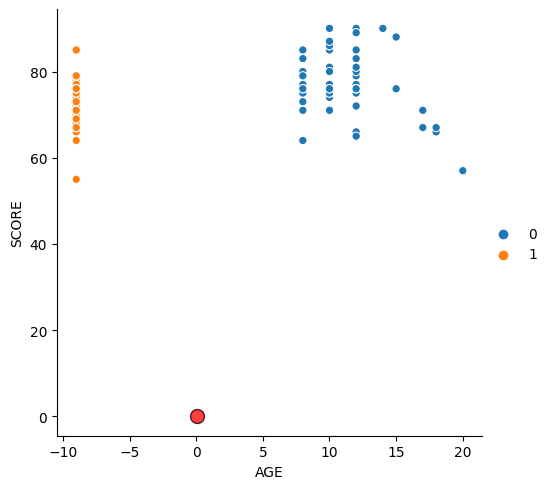

In [36]:
sn.relplot(x='AGE', y='SCORE', hue=kmeans.labels_, data=scotchClnoGeo)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', edgecolor='black', alpha=0.5, s=100)

Running the Elbow method, to examine which would a be better option for cluster selection. And the choice would be between 2 and 3, as the elbow method results in.

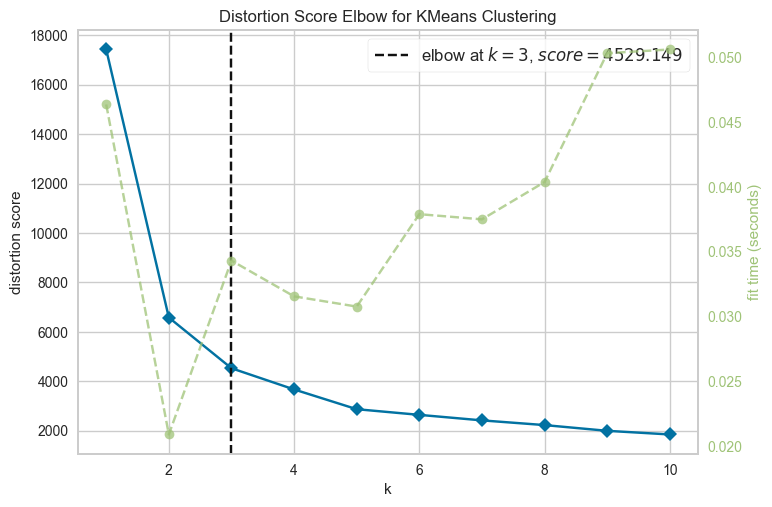

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scotchClnoGeo)
visualizer.show()

In [38]:
scotchClnoGeo.describe()

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,salt.1,arome.1,ling,long,very,quick,AGE,DIST,SCORE,%
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.073394,0.018349,0.018349,0.036697,0.091743,0.192661,0.018349,0.247706,0.045872,0.036697,...,0.073394,0.064220,0.100917,0.220183,0.036697,0.055046,4.357798,3.192661,75.587156,41.144037
std,0.261987,0.134829,0.134829,0.188886,0.289996,0.396210,0.134829,0.433674,0.210173,0.188886,...,0.261987,0.246277,0.302611,0.416284,0.188886,0.229123,9.833355,0.855019,6.947170,2.672613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,55.000000,40.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,3.000000,71.000000,40.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,3.000000,76.000000,40.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,4.000000,79.000000,40.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,5.000000,90.000000,57.100000


In [39]:
scaler = StandardScaler()
X = scaler.fit_transform(scotchClnoGeo)
scotchClnoGeoScaled = pd.DataFrame(X, index=scotchClnoGeo.index, 
                             columns=scotchClnoGeo.columns)
scotchClnoGeoScaled

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,salt.1,arome.1,ling,long,very,quick,AGE,DIST,SCORE,%
0,-0.281439,7.314369,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,-0.573819,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,-0.531369,-0.195180,-0.241355,-1.364692,-1.401337,-0.952558,-0.430037
1,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,-0.573819,-0.219265,-0.19518,...,-0.281439,-0.261968,2.98481,-0.531369,-0.195180,-0.241355,0.780761,0.948598,1.071959,0.697645
2,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,-0.573819,-0.219265,-0.19518,...,3.553168,-0.261968,-0.33503,-0.531369,-0.195180,-0.241355,0.576432,0.948598,1.361176,-0.430037
3,-0.281439,-0.136717,-0.136717,-0.19518,3.146427,-0.488504,-0.136717,-0.573819,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,-0.531369,-0.195180,-0.241355,1.393748,-1.401337,-1.386383,1.825327
4,-0.281439,-0.136717,-0.136717,-0.19518,3.146427,-0.488504,-0.136717,-0.573819,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,-0.531369,-0.195180,-0.241355,0.576432,2.123565,1.361176,-0.430037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,1.742710,-0.219265,-0.19518,...,-0.281439,3.817254,-0.33503,-0.531369,-0.195180,-0.241355,-1.364692,-1.401337,-1.241775,-0.430037
105,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,1.742710,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,-0.531369,-0.195180,-0.241355,0.576432,-0.226370,-0.084908,-0.430037
106,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,1.742710,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,1.881932,-0.195180,-0.241355,0.780761,-0.226370,0.059701,-0.430037
107,-0.281439,-0.136717,-0.136717,-0.19518,-0.317821,-0.488504,-0.136717,1.742710,-0.219265,-0.19518,...,-0.281439,-0.261968,-0.33503,-0.531369,5.123475,-0.241355,0.576432,-0.226370,0.059701,0.697645


<Figure size 800x550 with 0 Axes>

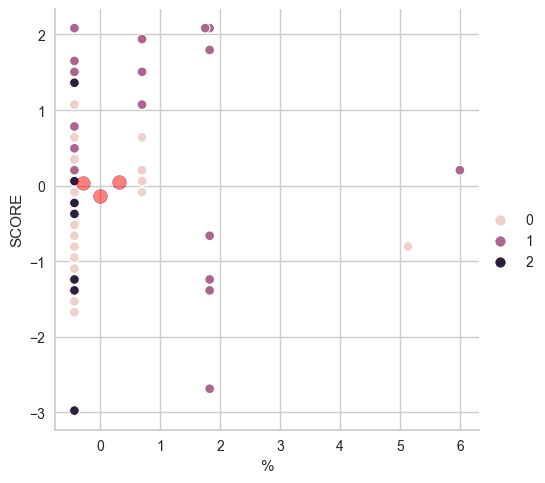

In [44]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scotchClnoGeoScaled)
plt.figure()
sn.relplot(x='%', y='SCORE', hue=kmeans.labels_, data=scotchClnoGeoScaled)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', edgecolor='black', s=100, alpha=0.5)

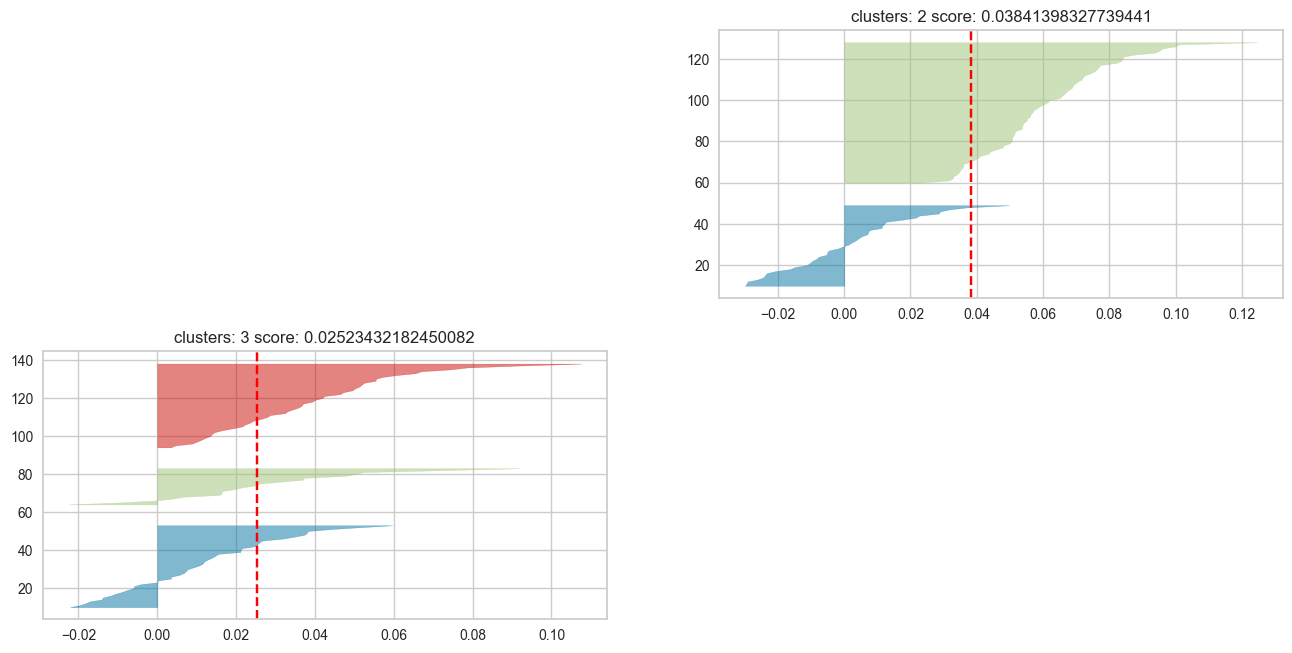

In [54]:
plt.figure(figsize=(16,  2 * 8))

scores = {}
best_kmeans = None
best_score = -1
for n_clusters in range(2, 4):
    plt.subplot(4, 2, n_clusters)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scotchClnoGeoScaled)
    scores[n_clusters] = visualizer.silhouette_score_
    if visualizer.silhouette_score_ > best_score:
        best_score = visualizer.silhouette_score_
        best_kmeans = kmeans
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

Comparing the scoresit seems like a 2 cluster approach gives us better results.

#### Q4 Clustering with Geographical Information

Summarising the process below, I have again categorised and encoded the regional data and performed the same steps as above. 

In [65]:
scotchClGeo=scotchCl

In [68]:
scotchClGeo.dropna(subset = ["SCORE"], inplace=True)

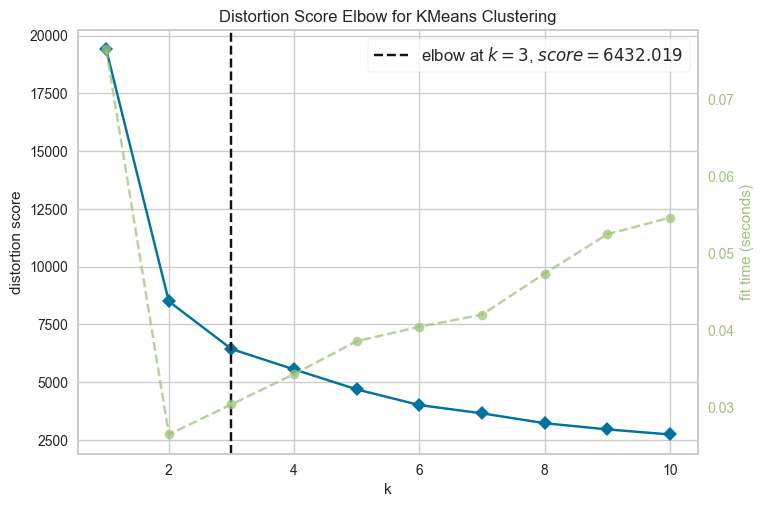

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scotchClGeo)
visualizer.show()

<Figure size 800x550 with 0 Axes>

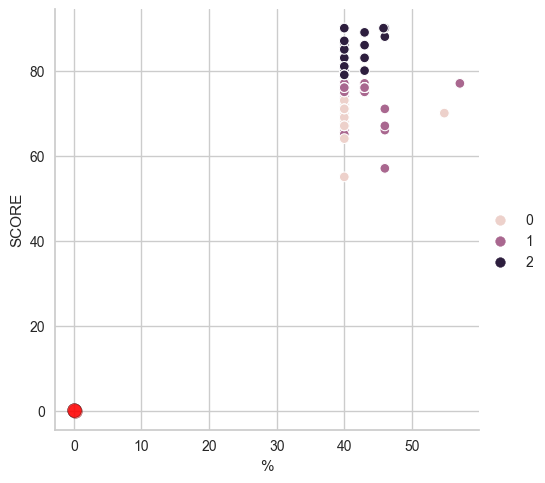

In [70]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scotchClGeo)
plt.figure()
sn.relplot(x='%', y='SCORE', hue=kmeans.labels_, data=scotchClGeo)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', edgecolor='black', s=100, alpha=0.5)

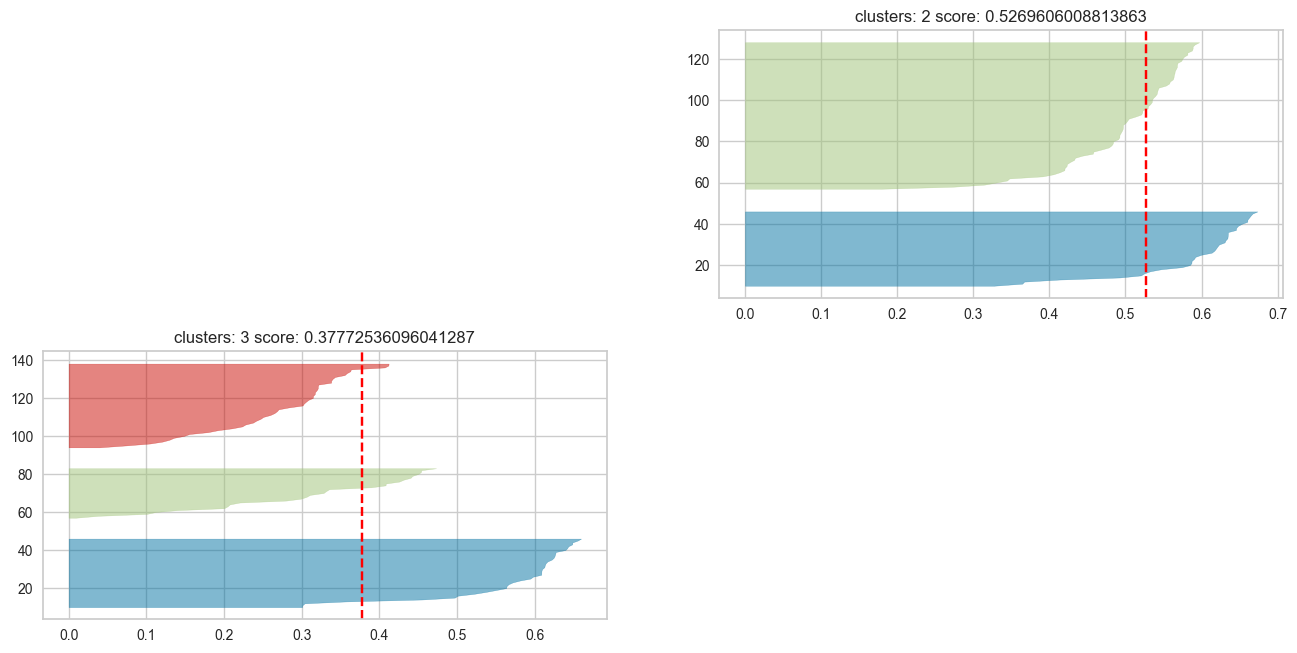

In [71]:
plt.figure(figsize=(16,  2 * 8))

scores = {}
best_kmeans = None
best_score = -1
for n_clusters in range(2, 4):
    plt.subplot(4, 2, n_clusters)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scotchClGeo)
    scores[n_clusters] = visualizer.silhouette_score_
    if visualizer.silhouette_score_ > best_score:
        best_score = visualizer.silhouette_score_
        best_kmeans = kmeans
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')